In [ ]:
# Install Kaggle API and authenticate
!pip install -q kaggle
from google.colab import files
files.upload()

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Download and unzip the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip -d /content/

# Import necessary libraries
import pandas as pd
from glob import glob
import shutil
import os

# Load metadata
metadata_path = "/content/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

# Map lesion types to readable names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['cell_type'] = df['dx'].map(lesion_type_dict)

# List the contents of the image directories
image_folders = [
    '/content/HAM10000_images_part_1',
    '/content/HAM10000_images_part_2',
    '/content/ham10000_images_part_1',
    '/content/ham10000_images_part_2'
]

# Get all image paths from the relevant directories
image_paths = []
for folder in image_folders:
    if os.path.exists(folder):
        image_paths.extend(glob(os.path.join(folder, '*.jpg')))

# Create a dictionary that maps image ids to their paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in image_paths
}

# Add the image paths to the DataFrame
df['image_path'] = df['image_id'].map(imageid_path_dict.get)

# Function to check the mapping of images to their classes
def verify_mapping_and_separate_classes(df):
    # Check the mapping for any None values
    unmapped_images = df[df['image_path'].isna()]
    if not unmapped_images.empty:
        print("Unmapped images:")
        print(unmapped_images)
    else:
        print("All images are mapped correctly.")

    # Create directories for each class
    output_dir = "/content/skin_cancer_images"
    os.makedirs(output_dir, exist_ok=True)

    # Create a subfolder for each class
    for lesion in df['cell_type'].unique():
        class_folder = os.path.join(output_dir, lesion)
        os.makedirs(class_folder, exist_ok=True)

    # Move images to respective class folders
    for index, row in df.iterrows():
        image_path = row['image_path']
        if pd.notna(image_path):
            class_folder = os.path.join(output_dir, row['cell_type'])
            shutil.copy(image_path, class_folder)

    print(f"Images are separated into respective folders under {output_dir}.")

# Call the function to verify mapping and separate the images
verify_mapping_and_separate_classes(df)

# Display data distribution (number of images per class)
class_counts = df['cell_type'].value_counts()
print("Data distribution (Number of images per class):")
print(class_counts)

# Save the counts in a text file
class_counts.to_csv('/content/class_counts.csv', header=True)



Streaming output truncated to the last 5000 lines.
  inflating: /content/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029343.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029344.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029345.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029346.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029347.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029348.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029349.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029350.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_002

Epoch [1/300], Step [1/8], D Loss: 0.6921, G Loss: 0.4343
Epoch [2/300], Step [1/8], D Loss: 0.6754, G Loss: 1.3014
Epoch [3/300], Step [1/8], D Loss: 0.8251, G Loss: 1.2146
Epoch [4/300], Step [1/8], D Loss: 0.6344, G Loss: 1.7450
Epoch [5/300], Step [1/8], D Loss: 0.3551, G Loss: 2.8197
Epoch [6/300], Step [1/8], D Loss: 1.3375, G Loss: 2.2144
Epoch [7/300], Step [1/8], D Loss: 0.5155, G Loss: 1.2914
Epoch [8/300], Step [1/8], D Loss: 0.5159, G Loss: 1.4547
Epoch [9/300], Step [1/8], D Loss: 0.2743, G Loss: 2.1926
Epoch [10/300], Step [1/8], D Loss: 0.7926, G Loss: 0.9014
Epoch [11/300], Step [1/8], D Loss: 0.9959, G Loss: 2.9672
Epoch [12/300], Step [1/8], D Loss: 0.6165, G Loss: 0.9355
Epoch [13/300], Step [1/8], D Loss: 0.6270, G Loss: 1.4754
Epoch [14/300], Step [1/8], D Loss: 0.5997, G Loss: 0.9022
Epoch [15/300], Step [1/8], D Loss: 0.5019, G Loss: 1.4971
Epoch [16/300], Step [1/8], D Loss: 0.5095, G Loss: 1.8981
Epoch [17/300], Step [1/8], D Loss: 0.5878, G Loss: 1.1886
Epoch 

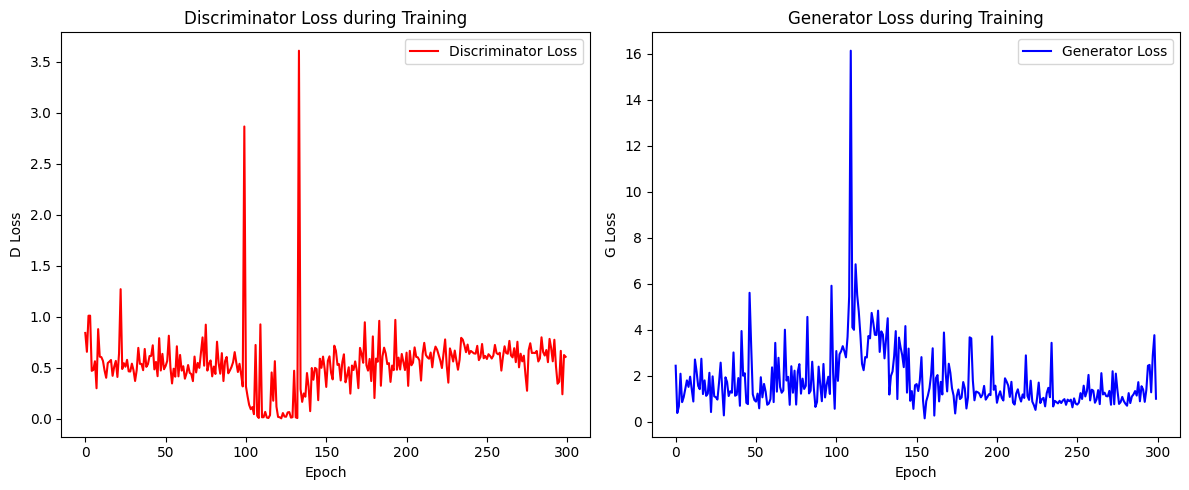

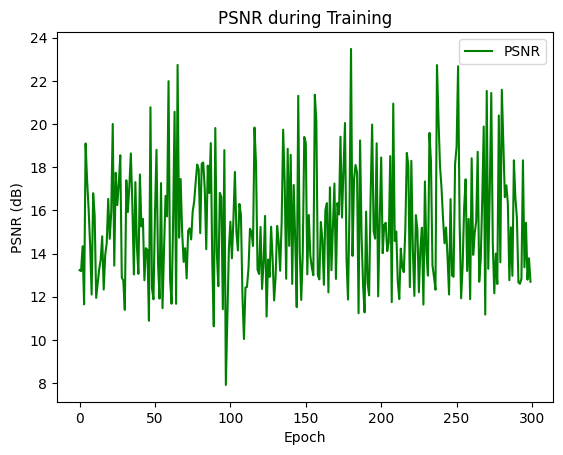

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 1. Dataset Preparation: Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, high_res_path, transform=None, scale_factor=4):
        self.high_res_images = self.load_images(high_res_path)
        self.transform = transform
        self.scale_factor = scale_factor

    def load_images(self, path):
        images = []
        for filename in os.listdir(path):
            if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                images.append(os.path.join(path, filename))
        return images

    def __len__(self):
        return len(self.high_res_images)

    def __getitem__(self, idx):
        high_res_img = Image.open(self.high_res_images[idx]).convert('RGB')

        low_res_img = high_res_img.resize(
            (high_res_img.width // self.scale_factor, high_res_img.height // self.scale_factor),
            Image.BICUBIC
        )

        if self.transform:
            high_res_img = self.transform(high_res_img)
            low_res_img = self.transform(low_res_img)

        return low_res_img, high_res_img


# 2. Transformations: Resize to fixed size, normalize, and add augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# 3. Generator Architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Generator layers with Residual connections
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.residual_block = self.make_residual_block(64)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

        self.batch_norm = nn.BatchNorm2d(64)  # Batch Normalization

    def make_residual_block(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        res = self.residual_block(x)
        x = self.conv3(res + x)
        return x


# 4. Discriminator Architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Discriminator layers with Spectral Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.relu = nn.ReLU(inplace=True)

        # Fully connected layers
        self.fc1_input_size = self._get_fc_input_size()

        self.fc1 = nn.Linear(self.fc1_input_size, 1024)
        self.fc2 = nn.Linear(1024, 1)

    def _get_fc_input_size(self):
        dummy_input = torch.randn(1, 3, 256, 256)
        x = self.relu(self.conv1(dummy_input))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        return x.size(1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# 5. Loss Functions: Content loss (L1 loss) and Adversarial loss (Binary Cross Entropy)
def content_loss(generated, target):
    return torch.mean(torch.abs(generated - target))

def adversarial_loss(discriminator_output, target_label):
    return nn.BCELoss()(discriminator_output, target_label)

# De-normalize function
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization ([-1, 1] -> [0, 1])
    tensor = tensor.clamp(0, 1)  # Ensure all values are in the range [0, 1]
    return tensor

# PSNR Calculation
def calculate_psnr(generated, target):
    mse = torch.mean((generated - target) ** 2)
    psnr = 10 * torch.log10(1 / mse)
    return psnr


# 6. Training Setup
high_res_path = '/content/skin_cancer_images/Dermatofibroma'

# Dataset and DataLoader
dataset = CustomImageDataset(high_res_path, transform, scale_factor=4)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Models
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 300
output_dir = "enhanced_images"
os.makedirs(output_dir, exist_ok=True)

# Track losses and PSNR
d_losses = []
g_losses = []
psnr_values = []

for epoch in range(num_epochs):
    for i, (low_res, high_res) in enumerate(dataloader):
        low_res, high_res = low_res.cuda(), high_res.cuda()

        real_labels = torch.ones(low_res.size(0), 1).cuda()
        fake_labels = torch.zeros(low_res.size(0), 1).cuda()

        # Train Discriminator
        optimizer_d.zero_grad()

        real_output = discriminator(high_res)
        real_loss = adversarial_loss(real_output, real_labels)

        fake_high_res = generator(low_res)
        fake_output = discriminator(fake_high_res.detach())
        fake_loss = adversarial_loss(fake_output, fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        fake_output = discriminator(fake_high_res)
        g_loss = adversarial_loss(fake_output, real_labels)

        c_loss = content_loss(fake_high_res, high_res)

        total_g_loss = g_loss + 0.1 * c_loss
        total_g_loss.backward()
        optimizer_g.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {total_g_loss.item():.4f}")

    # Save images and calculate PSNR at each epoch
    with torch.no_grad():
        low_res_sample = low_res[0].unsqueeze(0)
        enhanced_image = generator(low_res_sample.cuda())
        enhanced_image = enhanced_image.squeeze(0).cpu().detach()

        enhanced_image = denormalize(enhanced_image)
        high_res_image = denormalize(high_res[0]).cpu()

        psnr = calculate_psnr(enhanced_image, high_res_image)
        psnr_values.append(psnr.item())
        d_losses.append(d_loss.item())
        g_losses.append(total_g_loss.item())

        enhanced_image_np = (enhanced_image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        output_path = os.path.join(output_dir, f'enhanced_epoch_{epoch+1}.png')
        plt.imsave(output_path, enhanced_image_np)

# Plot D Loss and G Loss separately
plt.figure(figsize=(12, 5))

# Plot D Loss
plt.subplot(1, 2, 1)
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.xlabel('Epoch')
plt.ylabel('D Loss')
plt.legend()
plt.title('Discriminator Loss during Training')

# Plot G Loss
plt.subplot(1, 2, 2)
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel('Epoch')
plt.ylabel('G Loss')
plt.legend()
plt.title('Generator Loss during Training')

plt.tight_layout()
plt.show()

# Optionally, plot PSNR
plt.plot(psnr_values, label="PSNR", color='green')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.title('PSNR during Training')
plt.show()


In [ ]:
import os
import zipfile
from google.colab import files

# Paths
input_folder = '/content/enhanced_images'  # Folder containing the images
output_zip_file = '/content/filtered_DF.zip'  # Output zip file path

# Create a zip file
with zipfile.ZipFile(output_zip_file, 'w') as zipf:
    for file_name in os.listdir(input_folder):
        # Check if the file matches the required naming pattern
        if file_name.startswith("enhanced_epoch_") and file_name.endswith(".png"):
            try:
                epoch_number = int(file_name.split("_")[-1].split(".")[0])
                if 30 <= epoch_number <= 298:  # Filter condition
                    # Add the file to the zip
                    zipf.write(os.path.join(input_folder, file_name), file_name)
            except ValueError:
                print(f"Skipping non-epoch file: {file_name}")

print(f"Filtered zip file is created at {output_zip_file}")

# Download the zip file
files.download(output_zip_file)


Filtered zip file is created at /content/filtered_DF.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>